<a href="https://colab.research.google.com/github/its-serah/AI-Brand-Creator/blob/Stable-diffusion-x4-crisp-upscaler/StableDiffusion_x4_Crisp_Upscaler_CLEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
!pip -q install opencv-python-headless==4.10.0.84

import gc, torch, numpy as np, cv2
from PIL import Image, ImageOps
from pathlib import Path
from google.colab import files
from diffusers import StableDiffusionUpscalePipeline, DPMSolverMultistepScheduler

# 0) Load / prepare pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"

if "pipe" not in globals():
    pipe = StableDiffusionUpscalePipeline.from_pretrained(
        "stabilityai/stable-diffusion-x4-upscaler",
        torch_dtype=torch.float16 if device=="cuda" else torch.float32,
        use_safetensors=True
    ).to(device)
    pipe.enable_attention_slicing()
    pipe.enable_vae_tiling()
    pipe.enable_sequential_cpu_offload()
    if device == "cuda":
        try: pipe.unet.to(memory_format=torch.channels_last)
        except: pass

pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config, use_karras_sigmas=True
)

# Edge-aware sharpen
def crisp_text_sharpen(pil_im, k=0.22):
    im = np.array(pil_im)[:, :, ::-1]  # RGB ->BGR
    im = cv2.bilateralFilter(im, d=5, sigmaColor=25, sigmaSpace=25)
    lap = cv2.Laplacian(im, cv2.CV_16S, ksize=3)
    lap = cv2.convertScaleAbs(lap)
    sharp = cv2.addWeighted(im, 1.0, lap, k, 0)
    return Image.fromarray(sharp[:, :, ::-1])  # back to RGB


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


###Process a new image

Saving WhatsApp Image 2025-09-20 at 12.29.58 PM.jpeg to WhatsApp Image 2025-09-20 at 12.29.58 PM.jpeg
Input: (512, 191)


  0%|          | 0/36 [00:00<?, ?it/s]

Saved: WhatsApp Image 2025-09-20 at 12.29.58 PM_sdx4_neutral.png | Output size: (2048, 752)


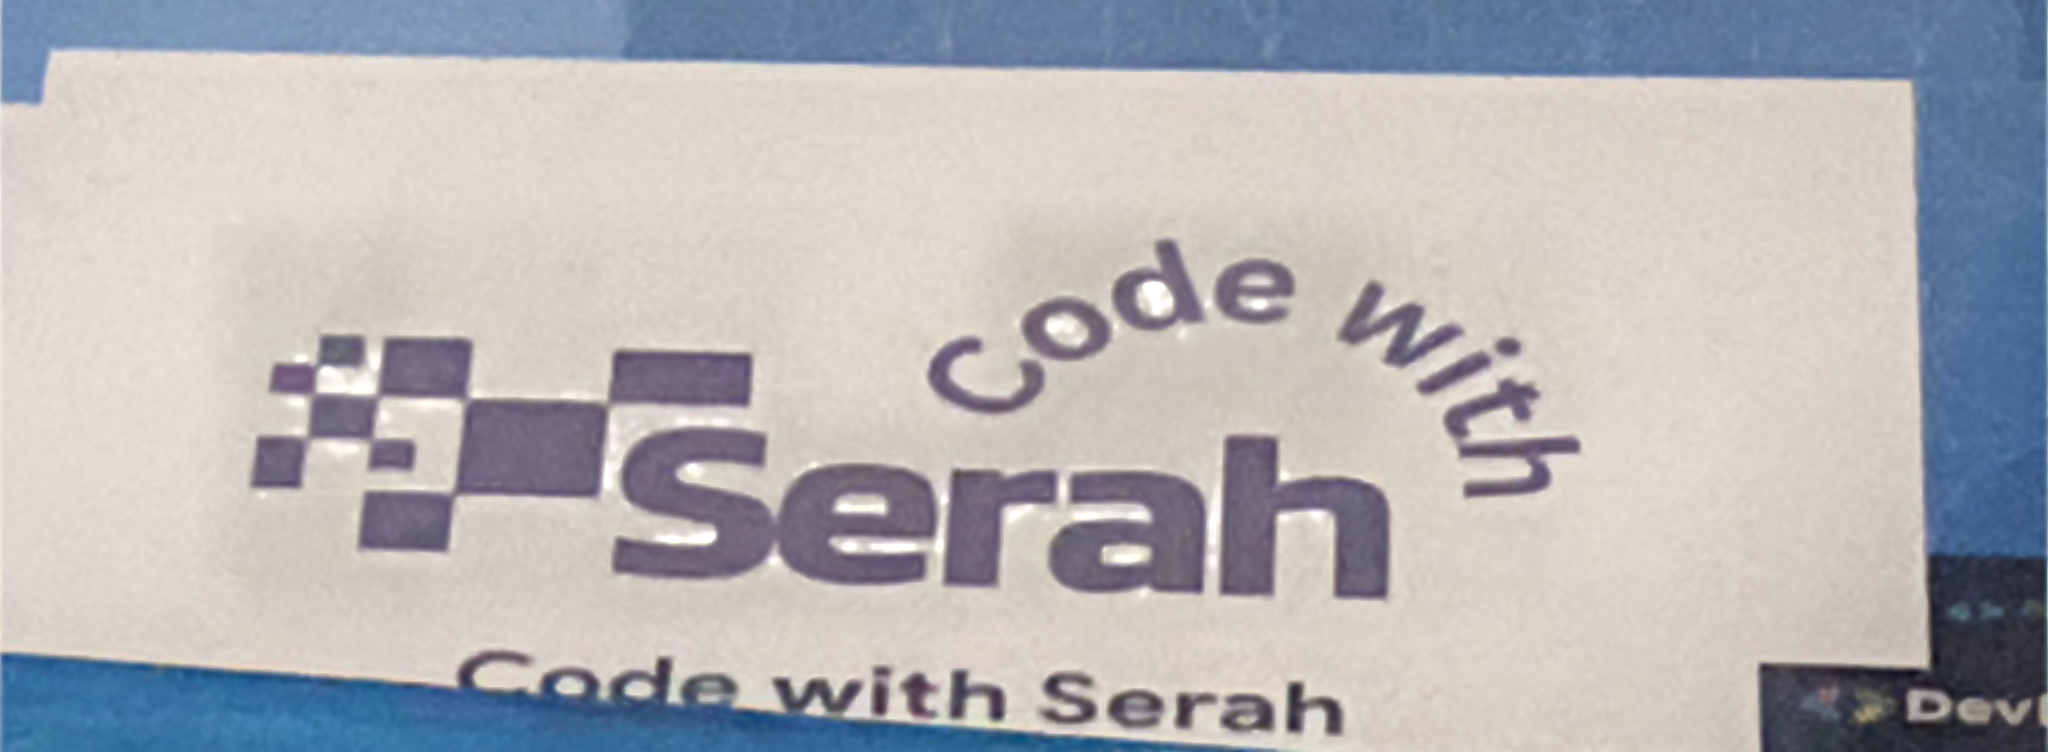

In [ ]:
# 1) Upload image
up = files.upload()
inp_path = list(up.keys())[0]
img = Image.open(inp_path).convert("RGB")
img = ImageOps.exif_transpose(img)

# keep input modest so 4× fits GPU memory
max_in = 512
w, h = img.size
scale = min(1.0, max_in / max(w, h))
if scale < 1.0:
    img = img.resize((int(w*scale), int(h*scale)), Image.Resampling.LANCZOS)
print("Input:", img.size)

# 2) SD-x4 crisp upscale
prompt  = "clean, sharp, high-resolution logo; crisp edges; vector-like; high contrast; no extra elements"
negative = "blurry edges, ringing, ghosting, extra letters, deformation, artifacts, noise, grain, background texture, jpeg artifacts"

sd_out = pipe(
    prompt=prompt,
    image=img,
    negative_prompt=negative,
    guidance_scale=0.5,
    num_inference_steps=36,
    noise_level=0,
).images[0]

# 3) Choose preset
preset = "neutral"   # options: "thin", "neutral", "bold"
k_map = {"thin": 0.20, "neutral": 0.22, "bold": 0.28}

result = crisp_text_sharpen(sd_out, k=k_map[preset])

# 4) Save as PNG
out_path = Path(inp_path).with_name(Path(inp_path).stem + f"_sdx4_{preset}.png")
result.save(out_path)
print("Saved:", out_path, "| Output size:", result.size)
display(result)


gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()
